In [54]:
import pandas as pd
import numpy as np

import emcee
import scipy.optimize as op
import scipy
import corner
from multiprocessing import Pool
import multiprocessing
import time

from astropy.cosmology import FlatLambdaCDM
from astropy import cosmology
from astropy.coordinates import Distance
import astropy


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib

In [45]:
%matplotlib notebook

In [50]:
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('astropy version: {}'.format(astropy.__version__))
print('emcee version: {}'.format(emcee.__version__))
print('scipy version: {}'.format(scipy.__version__))
print('multiprocessing version: {}'.format(multiprocessing.__version__))

numpy version: 1.15.4
pandas version: 0.23.4
matplotlib version: 3.0.1
astropy version: 3.1.1
emcee version: 3.0rc2
scipy version: 1.2.0


NameError: name 'multiprocessing' is not defined

# Figure 8

Create Figure 8 (the RCF plot) in [Fremling et al. 2020](https://ui.adsabs.harvard.edu/abs/2019arXiv191012973F/abstract).

In [19]:
# BTS data
bts_df = pd.read_hdf('../data/final_rcf_table.h5')

In [21]:
z_sn = bts_df.z_sn.values
z_host = bts_df.z_host.values

norm_Ia = np.where( ( (bts_df.sn_type == 'Ia-norm') | 
                      (bts_df.sn_type == 'Ia') | 
                      (bts_df.sn_type == 'Ia-91bg') | 
                      (bts_df.sn_type == 'Ia-91T') | 
                      (bts_df.sn_type == 'Ia-99aa') | 
                      (bts_df.sn_type == 'ia')
                     | (bts_df.sn_type == 'Ia-norm*')
                     | (bts_df.sn_type == 'Ia-91T*')
                     | (bts_df.sn_type == 'Ia-91T**')
                     | (bts_df.sn_type == 'SN Ia')
                    )
                  )

norm_cc = np.where( (bts_df.sn_type == 'IIb') | 
                    (bts_df.sn_type == 'Ib') | 
                    (bts_df.sn_type == 'IIP') | 
                    (bts_df.sn_type == 'Ib/c') | 
                    (bts_df.sn_type == 'Ic-norm') | 
                    (bts_df.sn_type == 'IIn') | 
                    (bts_df.sn_type == 'IIL') | 
                    (bts_df.sn_type == 'Ic-broad') | 
                    (bts_df.sn_type == 'II') | 
                    (bts_df.sn_type == 'II-pec') | 
                    (bts_df.sn_type == 'Ib-pec') | 
                    (bts_df.sn_type == 'Ic') | 
                    (bts_df.sn_type == 'Ic-BL') | 
                    (bts_df.sn_type == 'IIP*') | 
                    (bts_df.sn_type == 'II*') | 
                    (bts_df.sn_type == 'Ibn') | 
                    (bts_df.sn_type == 'II**') | 
                    (bts_df.sn_type == 'Ib-norm') | 
                    (bts_df.sn_type == 'IIn*')
                  )

has_host_z = np.where((z_host > 0) & np.isfinite(z_host))
no_host = np.where((z_host < 0) | np.isnan(z_host))

has_host_cc = np.intersect1d(has_host_z, norm_cc)
has_host_ia = np.intersect1d(has_host_z, norm_Ia)

no_host_cc = np.intersect1d(no_host, norm_cc)
no_host_ia = np.intersect1d(no_host, norm_Ia)

z_mix = z_sn.copy()
z_mix[has_host_z] = z_host[has_host_z]

In [37]:
# prep data for analysis
d_l = Distance(z=z_mix, cosmology=flat_h0_70)
distmod = d_l.distmod.value

A_w1 = 0.0385226*3.1*bts_df.ebv_host.values
M_mix_w1 = bts_df.w1_host - distmod - A_w1

# tractor
tractor_gal = np.where(np.isfinite(M_mix_w1)
                    & np.isfinite(bts_df.sep)
                    & (bts_df.sn_type != 'ambiguous')
                   )

hit_idx = np.where(np.isfinite(bts_df.z_host)
                   & (bts_df.z_host > 0)
                    & np.isfinite(bts_df.sep)
                    & (bts_df.sn_type != 'ambiguous')
                   )
miss_idx = np.where(np.isfinite(bts_df.z_host)
                    & (bts_df.z_host == -999)
                    & np.isfinite(bts_df.sep)
                    & (bts_df.sn_type != 'ambiguous')
                   )

tractor_gal_hit = np.intersect1d(tractor_gal[0], hit_idx[0])
tractor_gal_miss = np.intersect1d(tractor_gal[0], miss_idx[0])

tractor_Ia_hit = np.intersect1d(norm_Ia[0], tractor_gal_hit)
tractor_Ia_miss = np.intersect1d(norm_Ia[0], tractor_gal_miss)


# values for analysis
in_ned = np.append(np.ones_like(z_mix[tractor_Ia_hit]), 
                   np.zeros_like(z_mix[tractor_Ia_miss])
                  )
abs_mag = np.append(M_mix_w1[tractor_Ia_hit], 
                    M_mix_w1[tractor_Ia_miss])
z = np.append(z_mix[tractor_Ia_hit], z_mix[tractor_Ia_miss])

In [39]:
print('There are {} ({} hits) SNe Ia in the joint RCF analysis'.format(len(in_ned), sum(in_ned)))

There are 442 (213.0 hits) SNe Ia in the joint RCF analysis


## MCMC to measure RCF

In [40]:
def p_ab(x, y, a, b, c):
    return 1 / (1 + np.exp(a*x + b*y - c))

def lnprior(theta):
    a, b, c = theta
    if (0 < a < 1e6) and (0 < b < 1e6) and (-100 < c < 100):
        return 0.
    return -np.inf

def lnlike(theta, trials, x, y):
    a, b, c = theta

    return np.sum(np.log([scipy.stats.bernoulli.pmf(t, _p) for t, _p in zip(trials, p_ab(x, y, a, b, c))]))

def lnprob(theta, trials, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, trials, x, y)

### Get p(z) and p(M)

In [41]:
def p_z(x, a, c):
    return 1 / (1 + np.exp(a*x - c))

def lnprior_z(theta):
    a, c = theta
    if (0 < a < 1e6) and (-100 < c < 100):
        return 0.
    return -np.inf

def lnlike_z(theta, trials, x):
    a, c = theta

    return np.sum(np.log([scipy.stats.bernoulli.pmf(t, _p) for t, _p in zip(trials, p_z(x, a, c))]))

def lnprob_z(theta, trials, x):
    lp = lnprior_z(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_z(theta, trials, x)

#### Run full RCF solution

In [47]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [(25, 1, -10)], args=(in_ned, z, abs_mag))

ndim, nwalkers = 3, 25
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
max_n = 10000

In [48]:
a, b, c = result["x"]
p_ab(0.005, -24, a, b, c)

0.990962251754404

In [55]:
old_tau = np.inf

with Pool(4) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                      args=(in_ned, z, abs_mag), 
                                      pool=pool)
    start = time.time()
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        if sampler.iteration % 100:
            continue

        tau = sampler.get_autocorr_time(tol=0)

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

 37%|███▋      | 3700/10000 [19:34<32:38,  3.22it/s]  

Multiprocessing took 1174.7 seconds


### Run p(z)

In [58]:
Ia_hit_ignore_wise = np.intersect1d(norm_Ia[0], hit_idx)
Ia_miss_ignore_wise = np.intersect1d(norm_Ia[0], miss_idx)

in_ned_ignore_wise = np.append(np.ones_like(z_mix[Ia_hit_ignore_wise]), 
                               np.zeros_like(z_mix[Ia_miss_ignore_wise])
                              )
z_ignore_wise = np.append(z_mix[Ia_hit_ignore_wise], z_mix[Ia_miss_ignore_wise])

In [59]:
nll = lambda *args: -lnlike_z(*args)
result = op.minimize(nll, [(25, 1)], args=(in_ned_ignore_wise, z_ignore_wise))
a, c = result["x"]

ndim, nwalkers = 2, 25
pos_z = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
max_n = 5000

In [60]:
old_tau = np.inf

with Pool(4) as pool:
    sampler_z = emcee.EnsembleSampler(nwalkers, ndim, lnprob_z, 
                                      args=(in_ned_ignore_wise, z_ignore_wise), 
                                      pool=pool)
    start = time.time()
    for sample in sampler_z.sample(pos_z, iterations=max_n, progress=True):
        if sampler_z.iteration % 100:
            continue

        tau = sampler_z.get_autocorr_time(tol=0)

        # Check convergence
        converged = np.all(tau * 100 < sampler_z.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

 60%|██████    | 3000/5000 [18:12<11:08,  2.99it/s]

Multiprocessing took 1092.8 seconds


In [66]:
z_grid = np.linspace(0, 0.2, 1001)
autocorr_z = sampler_z.get_autocorr_time(tol=0)
n_burn_z = 5*np.ceil(np.max(autocorr_z)).astype(int)
samples_z = sampler_z.get_chain(discard=n_burn_z, flat=True)

p_z_1d_grid = np.empty((len(z_grid),len(samples_z)))
for grid_num, redshift in enumerate(z_grid):
    p_z_1d_grid[grid_num] = p_z(redshift, samples_z[:,0], samples_z[:,1])
p_z5, p_z50, p_z95 = np.percentile(p_z_1d_grid, (5,50,95), axis=1)

#### Run p(M_w1)

In [67]:
nll = lambda *args: -lnlike_z(*args)
result = op.minimize(nll, [(0, -18)], args=(in_ned, abs_mag))
b, c = result["x"]

ndim, nwalkers = 2, 20
pos_m = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
max_n = 5000

In [68]:
old_tau = np.inf
with Pool(4) as pool:
    sampler_m = emcee.EnsembleSampler(nwalkers, ndim, lnprob_z, 
                                      args=(in_ned, abs_mag), 
                                      pool=pool)
    start = time.time()
    for sample in sampler_m.sample(pos_m, iterations=max_n, progress=True):
        if sampler_m.iteration % 100:
            continue

        tau = sampler_m.get_autocorr_time(tol=0)

        # Check convergence
        converged = np.all(tau * 100 < sampler_m.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau    
    
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

 56%|█████▌    | 2800/5000 [13:33<10:33,  3.47it/s]

Multiprocessing took 814.2 seconds


In [69]:
m_grid = np.linspace(-27.5, -10, 2000)
autocorr_m = sampler_m.get_autocorr_time(tol=0)
n_burn_m = 5*np.ceil(np.max(autocorr_m)).astype(int)
samples_m = sampler_m.get_chain(discard=50, flat=True)

p_m_1d_grid = np.empty((len(m_grid),len(samples_m)))
for grid_num, m_w1 in enumerate(m_grid):
    p_m_1d_grid[grid_num] = p_z(m_w1, samples_m[:,0], samples_m[:,1])
p_m5, p_m50, p_m95 = np.percentile(p_m_1d_grid, (5,50,95), axis=1)

## Make plot

In [70]:
n_grid = 200
m_k_grid, redshift_grid = np.mgrid[-11.5:-24.5:n_grid*1j, 0:0.16:n_grid*1j]

max_posterior = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
p_m_z = p_ab(redshift_grid, m_k_grid, max_posterior[0], max_posterior[1], max_posterior[2])

In [71]:
y_tick_grid = np.linspace(0,n_grid,14)
del_ytick = np.diff(y_tick_grid)[0]
x_tick_grid = np.linspace(0,n_grid,5)
del_xtick = np.diff(x_tick_grid)[0]

In [72]:
def m_to_y(m_k_s, del_ytick=del_ytick):
    return (-11.5 - m_k_s)*del_ytick

def z_to_x(z, del_xtick=del_xtick):
    return z*del_xtick/0.04

In [73]:
flat_h0_70 = FlatLambdaCDM(H0=70,Om0=0.3)
z_w1_grid = np.linspace(0.0001,0.3,300)
det_limit = 20.699-Distance(z=z_w1_grid, cosmology=flat_h0_70).distmod.value

<IPython.core.display.Javascript object>


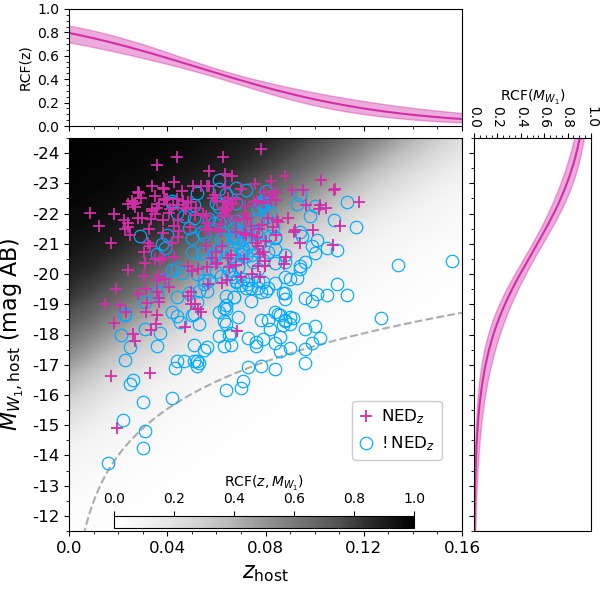

In [74]:
left, width = 0.115, 0.655
bottom, height = 0.115, 0.655
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.195]
rect_histy = [left_h, bottom, 0.195, height]

color_dict = {'hit': '#D32EA8', #'#0571b0', 
              'miss': '#00AAFF'} #'#ca0020'}

# start with a rectangular Figure
fig = plt.figure(figsize=(6, 6))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

p2d = axScatter.imshow(p_m_z, origin="lower",cmap='Greys',
                       vmin=0.0, vmax=1.0, zorder=-100)

axScatter.plot(z_to_x(z[in_ned==1]), m_to_y(abs_mag[in_ned==1]), 
               '+', color=color_dict['hit'], ms=8, mew=1.3, 
               label=r'$\mathrm{NED}_z$', zorder=10)
axScatter.plot(z_to_x(z[in_ned==0]), m_to_y(abs_mag[in_ned==0]), 
               'o', c='None', mec=color_dict['miss'], ms=9, mew=0.85,
               label=r'$!\mathrm{NED}_z$')

# axScatter.plot([0,n_grid], [m_to_y(-25.08), m_to_y(-25.08)], '--', 
#                    color = "0.6", alpha = 0.8, zorder = -10)
axScatter.plot(z_to_x(z_w1_grid), m_to_y(det_limit), '--', 
                   color = "0.6", alpha = 0.8, zorder = -10)



axScatter.set_xticks(x_tick_grid)
axScatter.set_xticklabels(['0.0', '0.04', '0.08', '0.12', '0.16'])
axScatter.set_yticks(y_tick_grid[:-1] + del_ytick/2)
axScatter.set_yticklabels(np.linspace(-24,-12,13)[::-1].astype(int))

axScatter.yaxis.set_minor_locator(MultipleLocator(del_ytick/2))
axScatter.xaxis.set_minor_locator(MultipleLocator(del_xtick/4))

axScatter.set_ylabel(r"$M_{W_1,\mathrm{host}}\;(\mathrm{mag\;AB})$", fontsize = 16)
axScatter.set_xlabel(r"$z_\mathrm{host}$", fontsize = 16)

axScatter.set_ylim(0,200)
axScatter.set_xlim(0,200)


axHistx.plot(z_grid, p_z50, color=color_dict['hit'])
axHistx.fill_between(z_grid, p_z5, p_z95, 
                     alpha=0.4, color=color_dict['hit'])

axHistx.set_xlim(0,0.16)
axHistx.set_ylim(0,1)
axHistx.xaxis.set_major_locator(MultipleLocator(0.04))
axHistx.xaxis.set_minor_locator(MultipleLocator(0.01))
axHistx.yaxis.set_major_locator(MultipleLocator(0.2))
axHistx.yaxis.set_minor_locator(MultipleLocator(0.05))
axHistx.set_xticklabels([])
axHistx.set_ylabel("RCF(z)")

axHisty.plot(p_m50, m_grid, color=color_dict['hit'])
axHisty.fill_betweenx(m_grid, p_m5, p_m95, 
                      alpha=0.4, color=color_dict['hit'])

axHisty.set_ylim(-11.5,-24.5)
axHisty.set_xlim(0,1)
axHisty.set_yticklabels([])
axHisty.xaxis.set_major_locator(MultipleLocator(0.2))
axHisty.xaxis.set_minor_locator(MultipleLocator(0.05))
axHisty.yaxis.set_major_locator(MultipleLocator(1))
axHisty.yaxis.set_minor_locator(MultipleLocator(0.5))
axHisty.tick_params(axis="x", which="both",
                    top=True, bottom=False,
                    labeltop=True, labelbottom=False,
                    labelrotation=270) 
axHisty.set_xlabel(r"$\mathrm{RCF}(M_{W_1})$")
axHisty.xaxis.set_label_position('top')

cbaxes = fig.add_axes([0.19, 0.12, 0.5, 0.02]) 
# cbaxes = fig.add_axes([0.25, 0.12, 0.5, 0.02]) 
fig.colorbar(p2d, cax = cbaxes, 
             orientation="horizontal", ticks=[0,0.2,0.4,0.6,0.8,1.0])
cbaxes.set_xlabel(r"$\mathrm{RCF}(z,M_{W_1})$", fontsize=10)
cbaxes.tick_params(axis="x", top=True, bottom=False,
                   labeltop=True, labelbottom=False)
cbaxes.xaxis.set_label_position('top')

axScatter.tick_params(axis='both', which='both', labelsize=12)
axScatter.legend(loc = 3, fontsize = 12, 
                 handlelength = 0.8, handletextpad = 0.5, 
                 framealpha = 0.99,
                 bbox_to_anchor=(.7,.16))
fig.savefig("conditional_Ia_Mw1.pdf")